In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from keras.utils.np_utils import to_categorical

In [2]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

In [3]:
import math 

In [4]:
train_df=pd.read_csv('mitbih_train.csv',header=None)
test_df=pd.read_csv('mitbih_test.csv',header=None)

In [5]:
test_df=pd.read_csv('mitbih_test.csv',header=None)

In [6]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()

In [7]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [8]:
Model_train=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))

In [9]:
Model_train.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
34809,0.959459,1.000000,0.807432,0.334459,0.000000,0.057432,0.118243,0.179054,0.206081,0.199324,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
73728,1.000000,0.800289,0.439942,0.156295,0.134588,0.188133,0.167873,0.147612,0.133140,0.130246,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
76452,1.000000,0.997809,0.945235,0.912377,0.899233,0.818182,0.690033,0.478642,0.293538,0.280394,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
80771,0.839319,0.858223,0.926276,1.000000,0.911153,0.550095,0.285444,0.185255,0.147448,0.137996,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
85713,1.000000,0.501818,0.516364,0.567273,0.607273,0.607273,0.618182,0.661818,0.643636,0.530909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


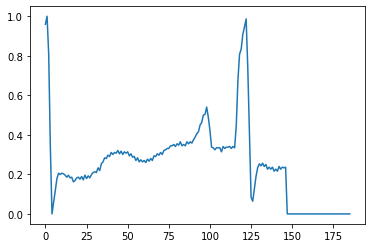

In [10]:
 plt.plot(Model_train.iloc[0,:186])

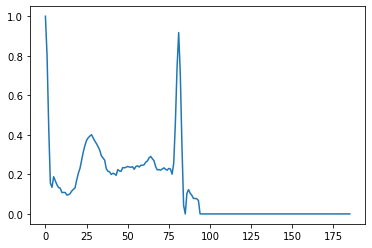

In [11]:
 plt.plot(Model_train.iloc[1,:186])

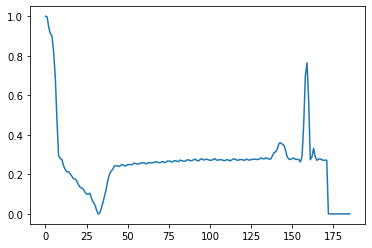

In [12]:
 plt.plot(Model_train.iloc[2,:186])

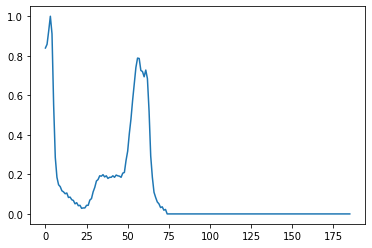

In [13]:
 plt.plot(Model_train.iloc[3,:186])

In [14]:
def add_gaussian_noise(code):
    noise=np.random.normal(0,0.5,186)
    return (code+noise)

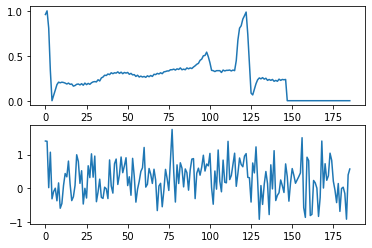

In [15]:
temp=Model_train.iloc[0,:186]
bruiter=add_gaussian_noise(temp)

plt.subplot(2,1,1)
plt.plot(Model_train.iloc[0,:186])

plt.subplot(2,1,2)
plt.plot(bruiter)

plt.show()

In [16]:
target_train=train_df[187]
target_test=test_df[187]

In [17]:
y_train=to_categorical(target_train)

In [18]:
y_test=to_categorical(target_test)

In [19]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
for i in range(len(X_train)):
    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [21]:
def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [22]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)
    

In [ ]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

model,history=network(X_train,y_train,X_test,y_test)

In [23]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

NameError: name 'history' is not defined

In [24]:
#Classes:['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
Classes = {
    0:'N', 
    1:'S', 
    2:'V', 
    3:'F',
    4:'Q'
}

Classes_index = {
    'N': 0, 
    'S': 1, 
    'V': 2, 
    'F': 3, 
    'Q': 4
}

In [25]:
feat_cols_name = [i for i in range(train_df.shape[1]-1)]

train_df.columns = feat_cols_name+["label"]
test_df.columns = feat_cols_name+["label"]

In [26]:
train_df["label"] = train_df["label"].astype(int)
test_df["label"] = test_df["label"].astype(int)

In [27]:
train_df["label"] = train_df["label"].map(Classes)
test_df["label"] = test_df["label"].map(Classes)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


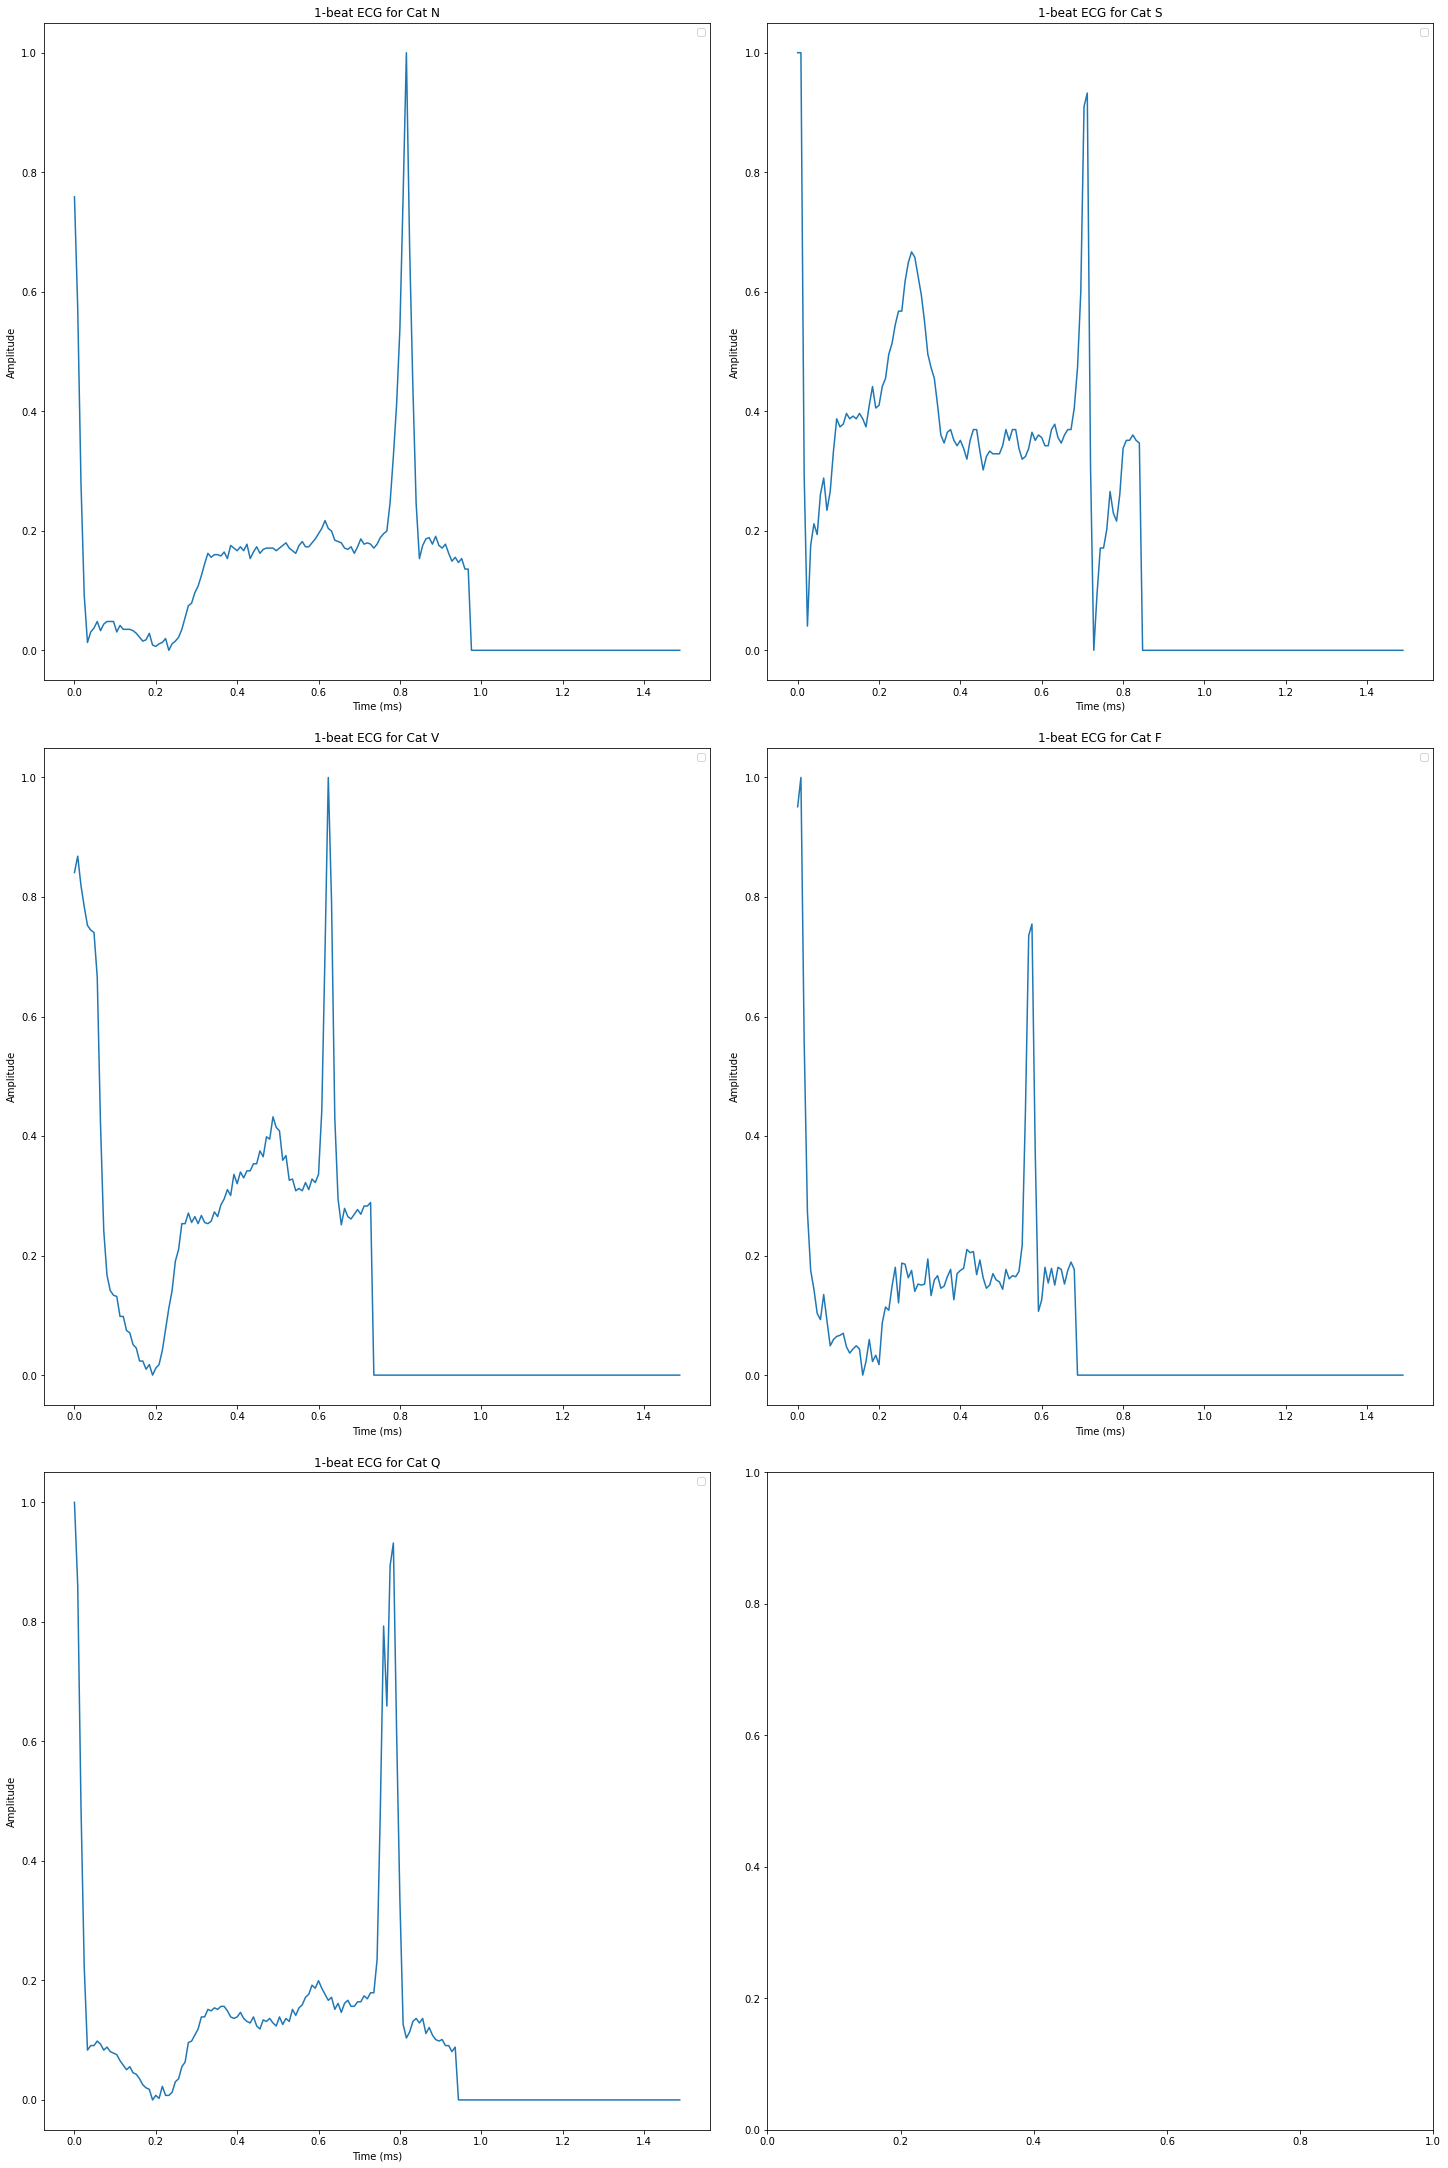

In [28]:
fig, axes= plt.subplots(math.ceil(len(Classes_index.keys())/2), 2, figsize=(20,30), constrained_layout=True)
X = np.arange(0, len(feat_cols_name))*8/1000

i = 0
for key, value in Classes_index.items():
    ax = axes[int(i/2), i%2]
    ax.plot(X, train_df[train_df["label"] == key][feat_cols_name].sample(1).values.reshape(-1,1))
    ax.legend()
    ax.set(title="1-beat ECG for Cat {}".format(key))
    ax.set(ylabel="Amplitude")
    ax.set(xlabel="Time (ms)")
    i+=1